In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN


!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
df= pd.read_csv('loan_eligibility_data.csv')

In [3]:
# checking for missing values
missing_values = df.isna().sum()
missing_values_sorted = missing_values.sort_values(ascending=True)

print(missing_values_sorted)

Loan_ID               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
Married               3
Gender               13
Loan_Amount_Term     14
Dependents           15
LoanAmount           22
Self_Employed        32
Credit_History       50
dtype: int64


In [4]:
# Removing missing values using mode for specific columns

columns_to_impute = ['Credit_History', 'Self_Employed', 'Dependents', 'Gender', 'Married']

# Impute missing values using mode for the specified columns
for column in columns_to_impute:
    mode_value = df[column].mode().iloc[0]
    df[column].fillna(mode_value, inplace=True)

# Impute missing values using median for specific columns
columns_to_impute = ['LoanAmount', 'Loan_Amount_Term']
for column in columns_to_impute:
    median_value = df[column].median()
    df[column].fillna(median_value, inplace=True)

In [5]:
# checking for missing values
missing_values = df.isna().sum()
missing_values_sorted = missing_values.sort_values(ascending=True)

print(missing_values_sorted)

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


In [6]:
# Check for duplicate rows in the entire DataFrame
duplicates = df.duplicated()
print(df[duplicates])

Empty DataFrame
Columns: [Loan_ID, Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History, Property_Area, Loan_Status]
Index: []


In [7]:
# checking and Dealing with outliers
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,145.752443,342.410423,0.855049
std,6109.041673,2926.248369,84.107233,64.428629,0.352339
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000
50%,3812.500000,1188.500000,128.000000,360.000000,1.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


<AxesSubplot:>

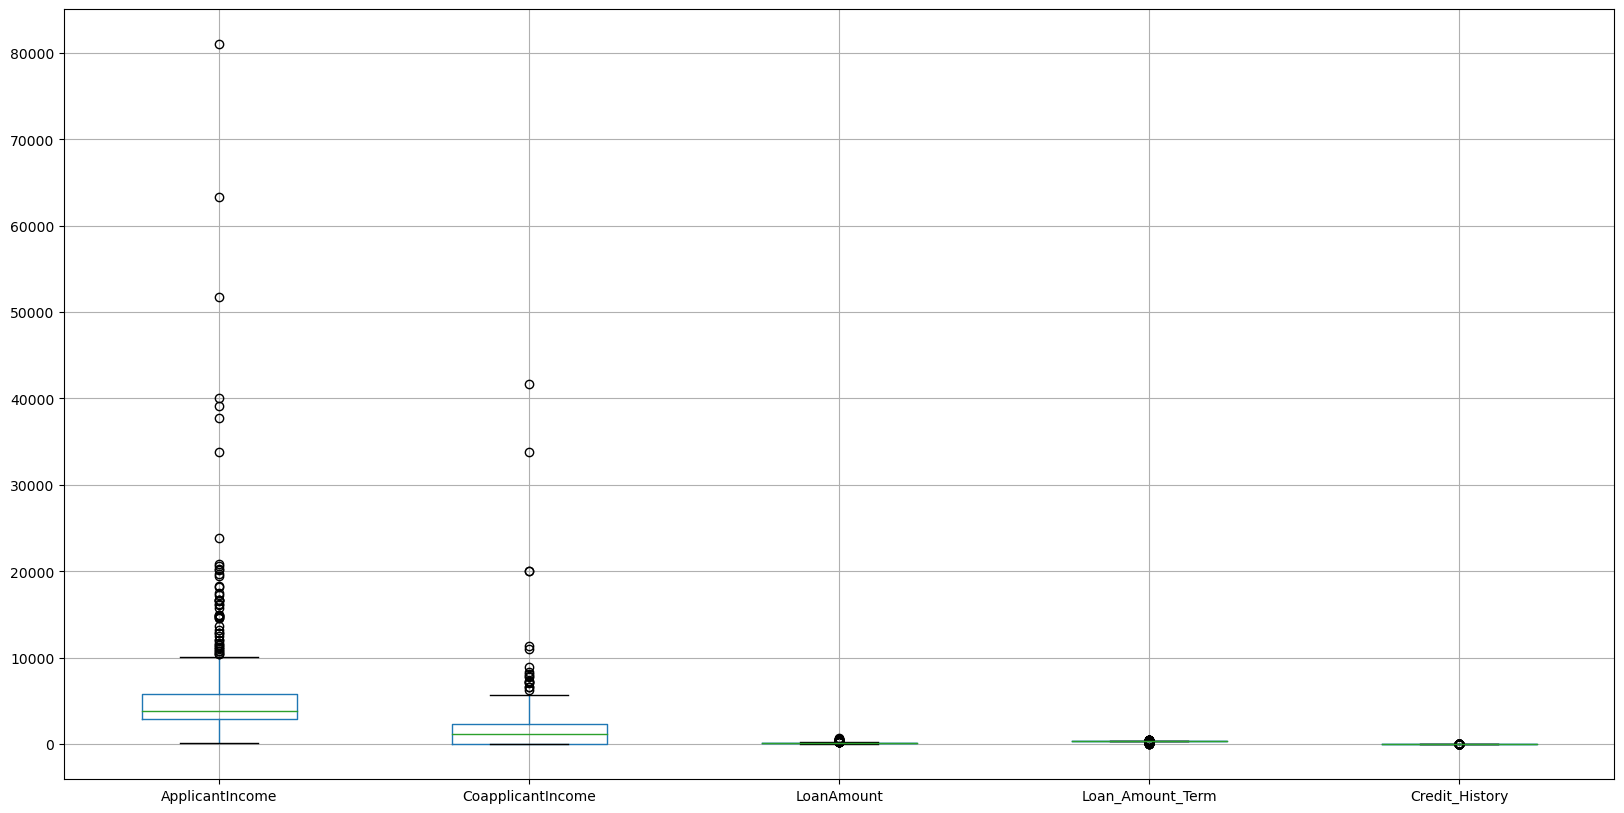

In [8]:
df.boxplot(figsize=(20,10))

In [9]:
# Dealing with outliers
def check_for_outlier(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return df

In [10]:
# Data Encoding 
df['Loan_Status'] = df['Loan_Status'].replace('Y',1)
df['Loan_Status'] = df['Loan_Status'].replace('N',0)

df['Married'] = df['Married'].replace('Yes',1)
df['Married'] = df['Married'].replace('No',0)

df['Self_Employed'] = df['Self_Employed'].replace('Yes',1)
df['Self_Employed'] = df['Self_Employed'].replace('No',0)

df['Property_Area']= df['Property_Area'].replace('Urban',0)
df['Property_Area']= df['Property_Area'].replace('Rural',1)
df['Property_Area']= df['Property_Area'].replace('Semiurban',2)

df['Dependents']= df['Dependents'].replace('0',0)
df['Dependents']= df['Dependents'].replace('1',1)
df['Dependents']= df['Dependents'].replace('2',2)
df['Dependents']= df['Dependents'].replace('3+',3)

df['Gender'] = df['Gender'].replace('Male',1)
df['Gender'] = df['Gender'].replace('Female',0)

df['Education'] = df['Education'].replace('Graduate',1)
df['Education'] = df['Education'].replace('Not Graduate',0)

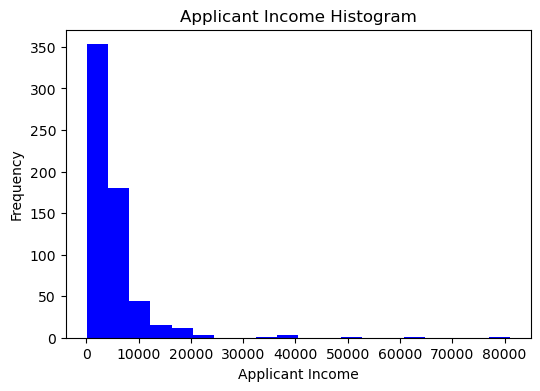

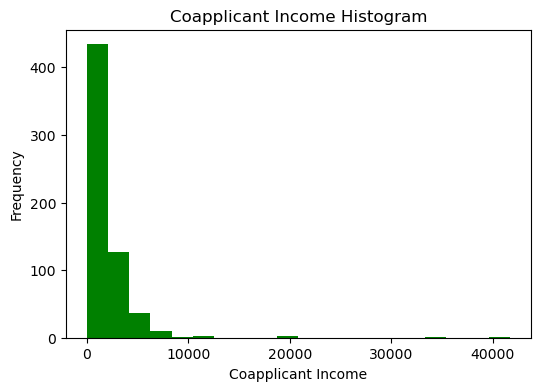

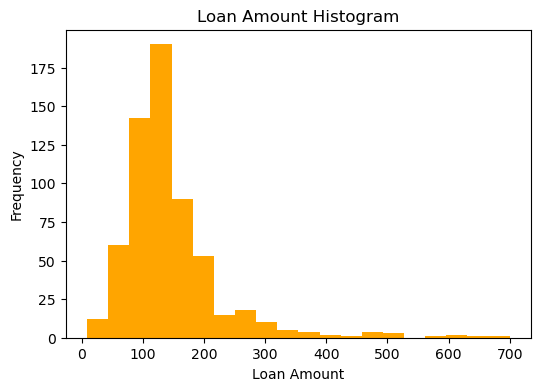

In [11]:
# Plot histogram for 'ApplicantIncome'
plt.figure(figsize=(6, 4))
plt.hist(df['ApplicantIncome'], bins=20, color='blue')
plt.title('Applicant Income Histogram')
plt.xlabel('Applicant Income')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for 'CoapplicantIncome'
plt.figure(figsize=(6, 4))
plt.hist(df['CoapplicantIncome'], bins=20, color='green')
plt.title('Coapplicant Income Histogram')
plt.xlabel('Coapplicant Income')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for 'LoanAmount'
plt.figure(figsize=(6, 4))
plt.hist(df['LoanAmount'], bins=20, color='orange')
plt.title('Loan Amount Histogram')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

In [12]:
# normalise due to right skewed using Square Root Transformation

columns_to_normalise = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
df[columns_to_normalise] = df[columns_to_normalise].apply(np.sqrt)

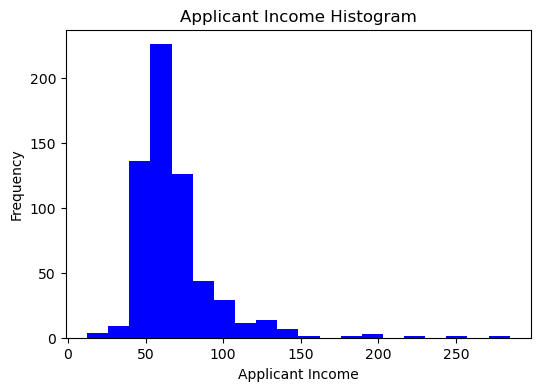

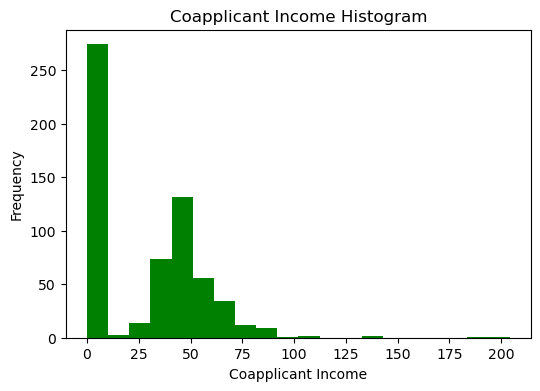

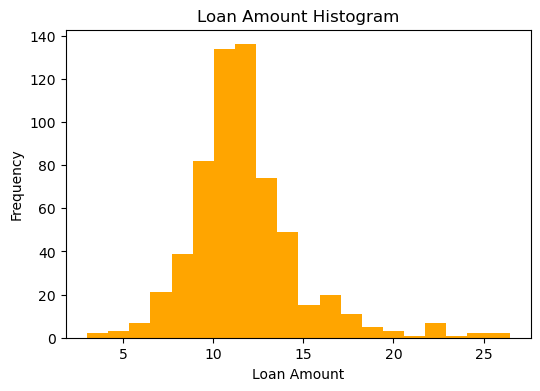

In [13]:
# Plot histogram for 'ApplicantIncome'
plt.figure(figsize=(6, 4))
plt.hist(df['ApplicantIncome'], bins=20, color='blue')
plt.title('Applicant Income Histogram')
plt.xlabel('Applicant Income')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for 'CoapplicantIncome'
plt.figure(figsize=(6, 4))
plt.hist(df['CoapplicantIncome'], bins=20, color='green')
plt.title('Coapplicant Income Histogram')
plt.xlabel('Coapplicant Income')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for 'LoanAmount'
plt.figure(figsize=(6, 4))
plt.hist(df['LoanAmount'], bins=20, color='orange')
plt.title('Loan Amount Histogram')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    int64  
 2   Married            614 non-null    int64  
 3   Dependents         614 non-null    int64  
 4   Education          614 non-null    int64  
 5   Self_Employed      614 non-null    int64  
 6   ApplicantIncome    614 non-null    float64
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    int64  
 12  Loan_Status        614 non-null    int64  
dtypes: float64(5), int64(7), object(1)
memory usage: 62.5+ KB


In [15]:
# add co-applicant and applcant income together feature modification 
df['sum_columns'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# Rename the 'sumed columns' column to a new name called Income
df = df.rename(columns={'sum_columns': 'Income'})

In [16]:
# Remove Duplicated and un useful data
df= df.drop('ApplicantIncome',axis=1)
df = df.drop('CoapplicantIncome',axis=1)
df = df.drop('Loan_ID',axis=1)

In [17]:
df.head(5)

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Income
0,1,0,0,1,0,11.313708,360.0,1.0,0,1,76.478755
1,1,1,1,1,0,11.313708,360.0,1.0,1,0,106.530834
2,1,1,0,1,1,8.124038,360.0,1.0,0,1,54.772256
3,1,1,0,0,0,10.954451,360.0,1.0,0,1,99.382465
4,1,0,0,1,0,11.874342,360.0,1.0,0,1,77.459667


In [19]:
df.shape

(614, 11)

In [20]:
df1 = df

In [21]:
# Dropping the id column and reassigning the variables to represent the independent variables 
X = df1.drop(["Loan_Status"], axis=1)
y = df1["Loan_Status"]

In [22]:
y. head(5)

0    1
1    0
2    1
3    1
4    1
Name: Loan_Status, dtype: int64

In [23]:
X. head(5)

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Income
0,1,0,0,1,0,11.313708,360.0,1.0,0,76.478755
1,1,1,1,1,0,11.313708,360.0,1.0,1,106.530834
2,1,1,0,1,1,8.124038,360.0,1.0,0,54.772256
3,1,1,0,0,0,10.954451,360.0,1.0,0,99.382465
4,1,0,0,1,0,11.874342,360.0,1.0,0,77.459667


In [24]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X, y)
feature_importance = rf_classifier.feature_importances_
feature_importance_df1 = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df1 = feature_importance_df1.sort_values(by='Importance', ascending=False)

# Print the feature importance by rank
print("Feature Importance:")
print(feature_importance_df1)

Feature Importance:
            Feature  Importance
7    Credit_History    0.267640
9            Income    0.261481
5        LoanAmount    0.226604
2        Dependents    0.054511
8     Property_Area    0.052146
6  Loan_Amount_Term    0.043492
1           Married    0.027951
3         Education    0.024057
4     Self_Employed    0.021931
0            Gender    0.020185


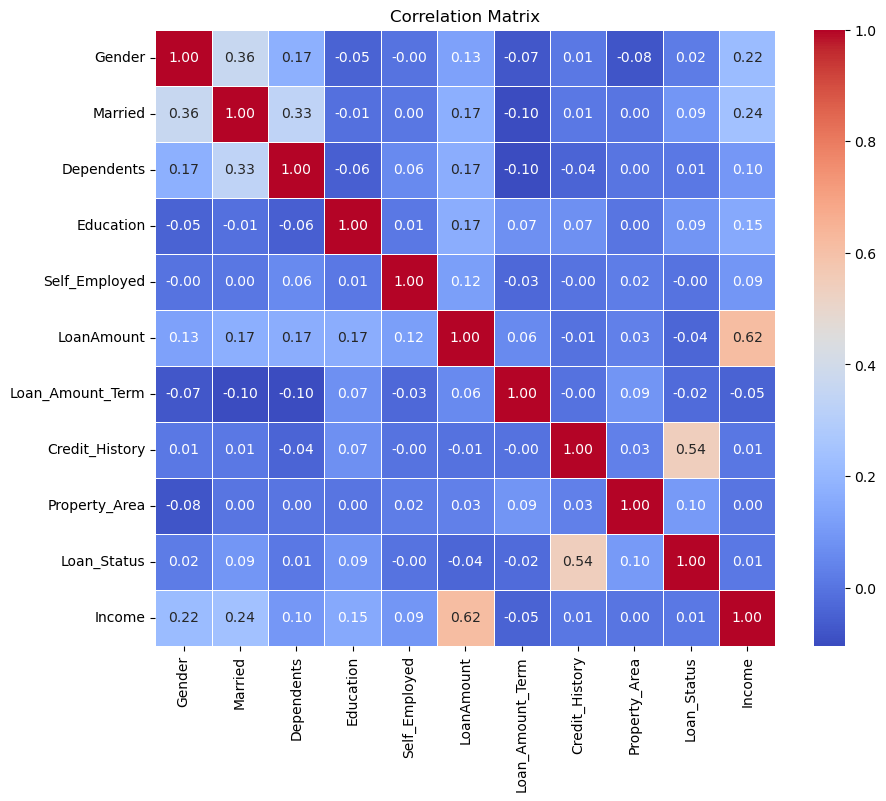

In [25]:
# Calculate the correlation matrix
correlation_matrix = df1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

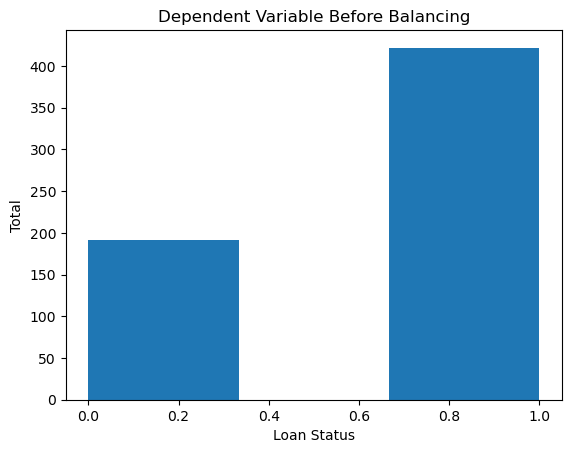

In [26]:
plt.hist(y, bins=3)
plt.title('Dependent Variable Before Balancing')
plt.xlabel('Loan Status')
plt.ylabel('Total')
plt.show()

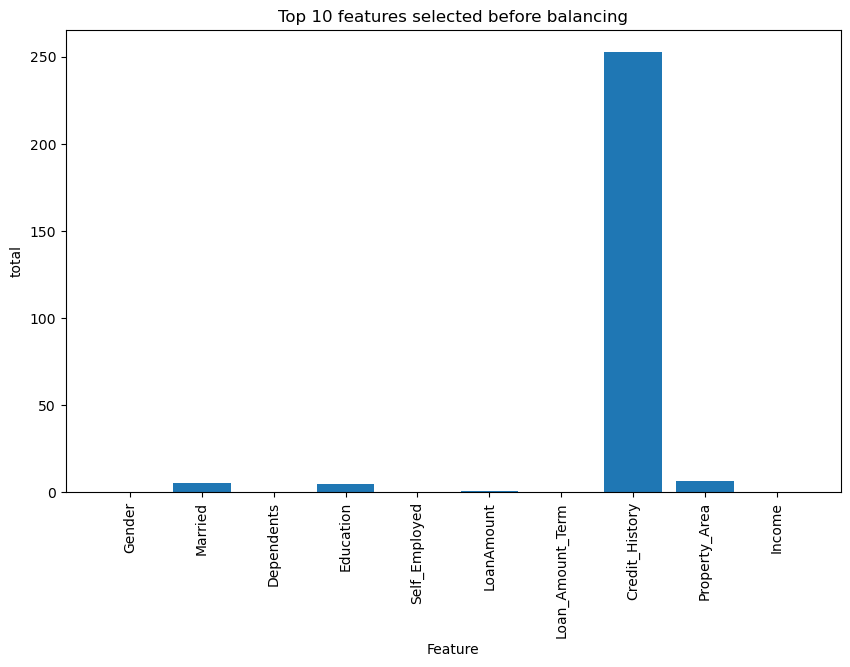

In [27]:
k = 10
selector = SelectKBest(f_classif, k=k)
selector.fit(X, y)
X_topk = selector.transform(X)

# Plot selected features before balancing
plt.figure(figsize=(10,6))
plt.bar(range(len(selector.scores_)), selector.scores_)
plt.xticks(range(len(selector.scores_)), X.columns, rotation=90)
plt.xlabel('Feature')
plt.ylabel('total')
plt.title('Top {} features selected before balancing'.format(k))
plt.show()

In [28]:
# Split the data into train and test sets with an 80/20 split
X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model_80 = xgb.XGBClassifier(random_state=42)# Create an XGBoost classifier
xgb_model_80.fit(X_train_80, y_train_80)# Train the model on the 80/20 split
y_pred_80 = xgb_model_80.predict(X_test_80)# Predict the target values using the testing data from the 80/20 split

# Evaluate the accuracy of the model on the 80/20 split
accuracy_80 = accuracy_score(y_test_80, y_pred_80)
print(f"Accuracy on 80/20 split: {accuracy_80:.2f}")

Accuracy on 80/20 split: 0.76


In [29]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test_80, y_pred_80)
df_cm = pd.DataFrame(cm, index=['0','1'], 
                     columns = ['control','Case'])
print(df_cm)

   control  Case
0       22    21
1        9    71


In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test_80,y_pred_80))

              precision    recall  f1-score   support

           0       0.71      0.51      0.59        43
           1       0.77      0.89      0.83        80

    accuracy                           0.76       123
   macro avg       0.74      0.70      0.71       123
weighted avg       0.75      0.76      0.74       123



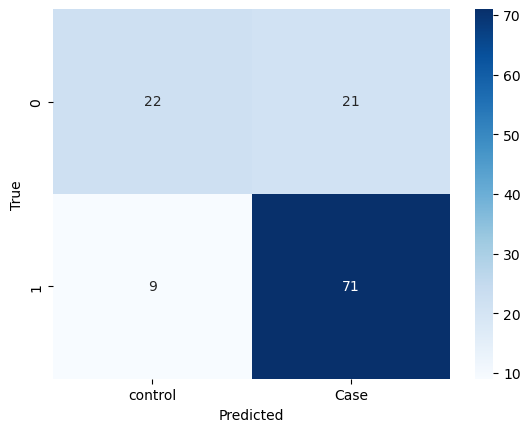

In [31]:
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

AUC-ROC score: 0.6973837209302325


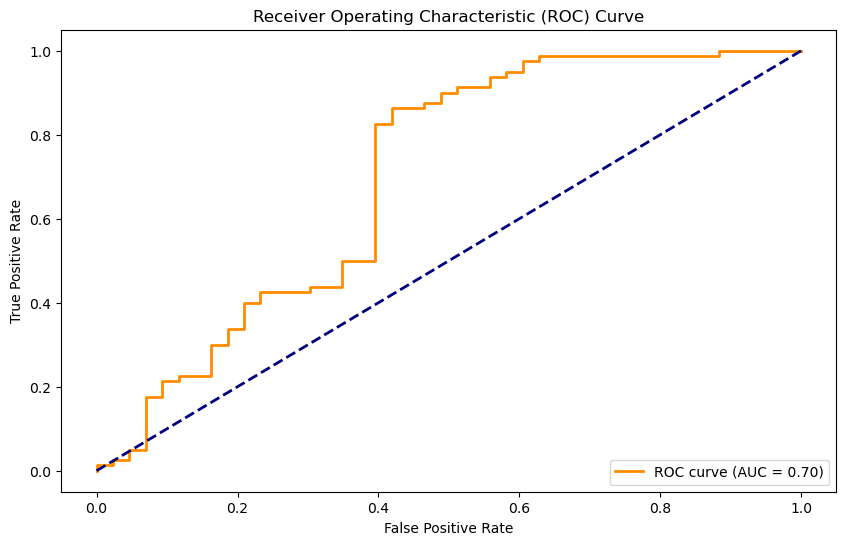

In [32]:
# Predict probabilities for the testing set
y_prob = xgb_model_80.predict_proba(X_test_80)[:,1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test_80, y_prob)
auc_roc = auc(fpr, tpr)
print("AUC-ROC score:", auc_roc)
# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [33]:
# repeat the process for 75/25 split

# Split the data into train and test sets with a 75/25 split
X_train_75, X_test_75, y_train_75, y_test_75 = train_test_split(X, y, test_size=0.25, random_state=42)

xgb_model_75 = xgb.XGBClassifier(random_state=42)# Create an XGBoost classifier
xgb_model_75.fit(X_train_75, y_train_75)# Train the model on the 75/25 split
y_pred_75 = xgb_model_75.predict(X_test_75)# Predict the target values using the testing data from the 75/25 split

# Evaluate the accuracy of the model on the 75/25 split
accuracy_75 = accuracy_score(y_test_75, y_pred_75)
print(f"Accuracy on 75/25 split: {accuracy_75:.2f}")

Accuracy on 75/25 split: 0.75


In [34]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test_75, y_pred_75)
df_cm = pd.DataFrame(cm, index=['0','1'], 
                     columns = ['control','Case'])

In [35]:

from sklearn.metrics import classification_report
print(classification_report(y_test_75,y_pred_75))

              precision    recall  f1-score   support

           0       0.71      0.50      0.59        54
           1       0.77      0.89      0.82       100

    accuracy                           0.75       154
   macro avg       0.74      0.70      0.71       154
weighted avg       0.75      0.75      0.74       154



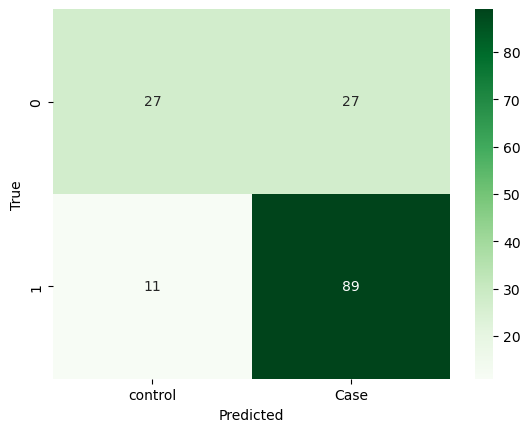

In [36]:
sns.heatmap(df_cm, annot=True, cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

AUC-ROC score: 0.7283333333333334


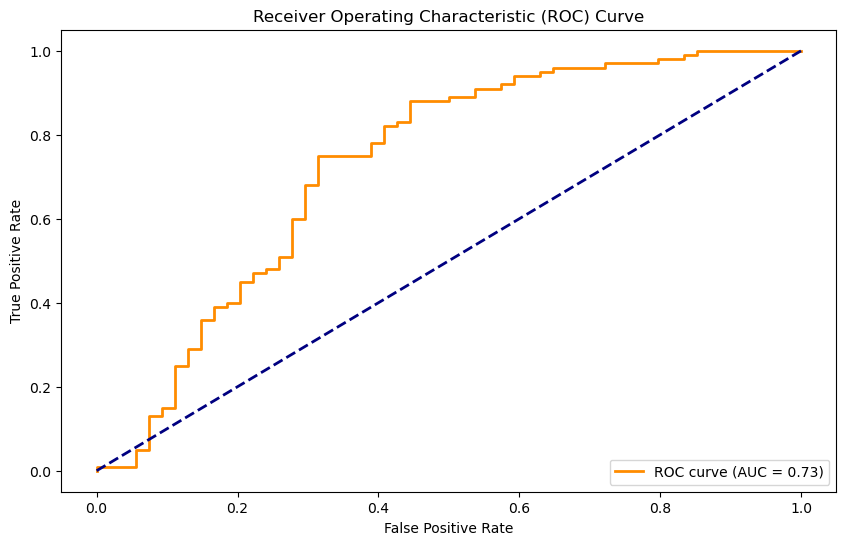

In [37]:
# Predict probabilities for the testing set
y_prob = xgb_model_75.predict_proba(X_test_75)[:,1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test_75, y_prob)
auc_roc = auc(fpr, tpr)
print("AUC-ROC score:", auc_roc)
# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [38]:
# Finally, let's repeat the process for 70/30 split

# Split the data into train and test sets with a 70/30 split
X_train_70, X_test_70, y_train_70, y_test_70 = train_test_split(X, y, test_size=0.3, random_state=42)


xgb_model_70 = xgb.XGBClassifier(random_state=42)
xgb_model_70.fit(X_train_70, y_train_70)
y_pred_70 = xgb_model_70.predict(X_test_70)

# Evaluate the accuracy of the model on the 70/30 split
accuracy_70 = accuracy_score(y_test_70, y_pred_70)
print(f"Accuracy on 70/30 split: {accuracy_70:.2f}")

Accuracy on 70/30 split: 0.77


In [39]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test_70, y_pred_70)
df_cm = pd.DataFrame(cm, index=['0','1'], 
                     columns = ['control','Case'])
print(df_cm)

   control  Case
0       34    31
1       11   109


In [40]:

from sklearn.metrics import classification_report
print(classification_report(y_test_70,y_pred_70))

              precision    recall  f1-score   support

           0       0.76      0.52      0.62        65
           1       0.78      0.91      0.84       120

    accuracy                           0.77       185
   macro avg       0.77      0.72      0.73       185
weighted avg       0.77      0.77      0.76       185



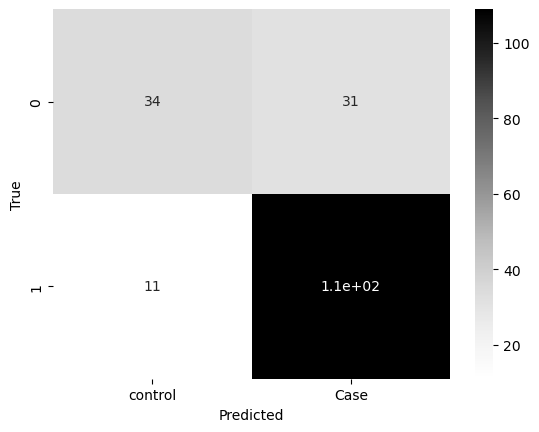

In [41]:
sns.heatmap(df_cm, annot=True, cmap='Greys')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

AUC-ROC score: 0.7503846153846153


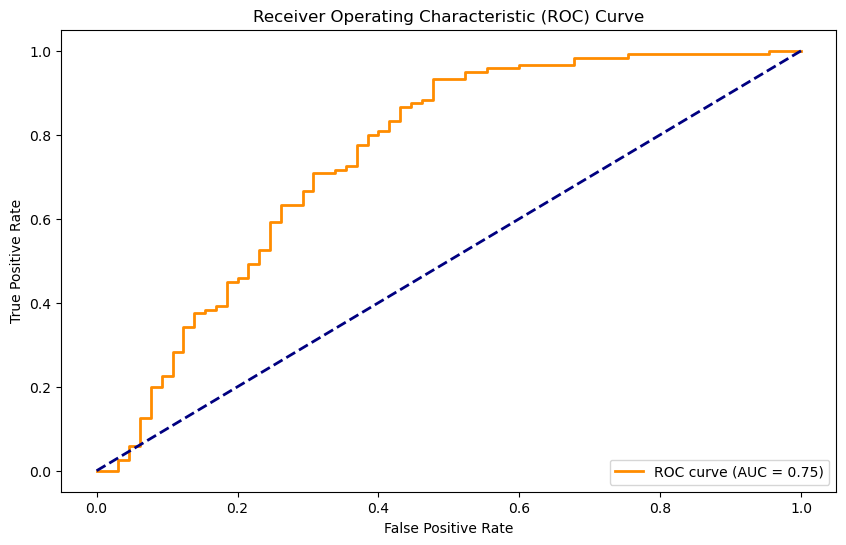

In [42]:
# Predict probabilities for the testing set
y_prob = xgb_model_70.predict_proba(X_test_70)[:,1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test_70, y_prob)
auc_roc = auc(fpr, tpr)
print("AUC-ROC score:", auc_roc)
# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [45]:
df3= df2

In [46]:
df3.head(5)

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Income
0,1,0,0,1,0,11.313708,360.0,1.0,0,1,76.478755
1,1,1,1,1,0,11.313708,360.0,1.0,1,0,106.530834
2,1,1,0,1,1,8.124038,360.0,1.0,0,1,54.772256
3,1,1,0,0,0,10.954451,360.0,1.0,0,1,99.382465
4,1,0,0,1,0,11.874342,360.0,1.0,0,1,77.459667


In [47]:
# Dropping the id column and reassigning the variables to represent the independent variables 
X = df3.drop(["Loan_Status"], axis=1)
y = df3["Loan_Status"]

In [48]:
# Perform oversampling on the data
X, y = SMOTE().fit_resample(X, y)
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

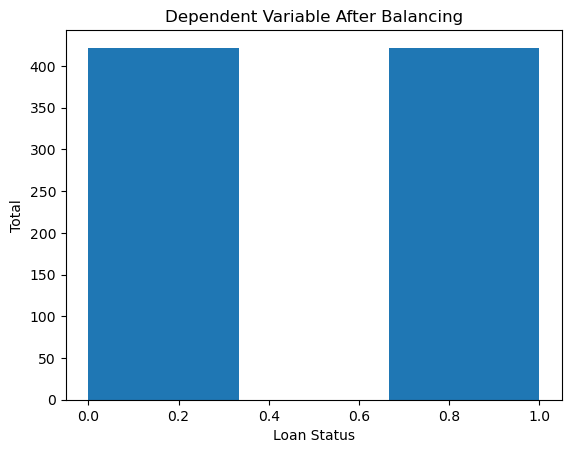

In [49]:
plt.hist(y, bins=3)
plt.title('Dependent Variable After Balancing')
plt.xlabel('Loan Status')
plt.ylabel('Total')
plt.show()

In [51]:
from collections import Counter

# Count the class distribution after resampling
counter_after = Counter(y_resampled)
print('After:', counter_after)


After: Counter({1: 422, 0: 422})


In [52]:
counter_after = Counter(X_resampled)
print('After:', counter_after)

After: Counter({'Gender': 1, 'Married': 1, 'Dependents': 1, 'Education': 1, 'Self_Employed': 1, 'LoanAmount': 1, 'Loan_Amount_Term': 1, 'Credit_History': 1, 'Property_Area': 1, 'Income': 1})


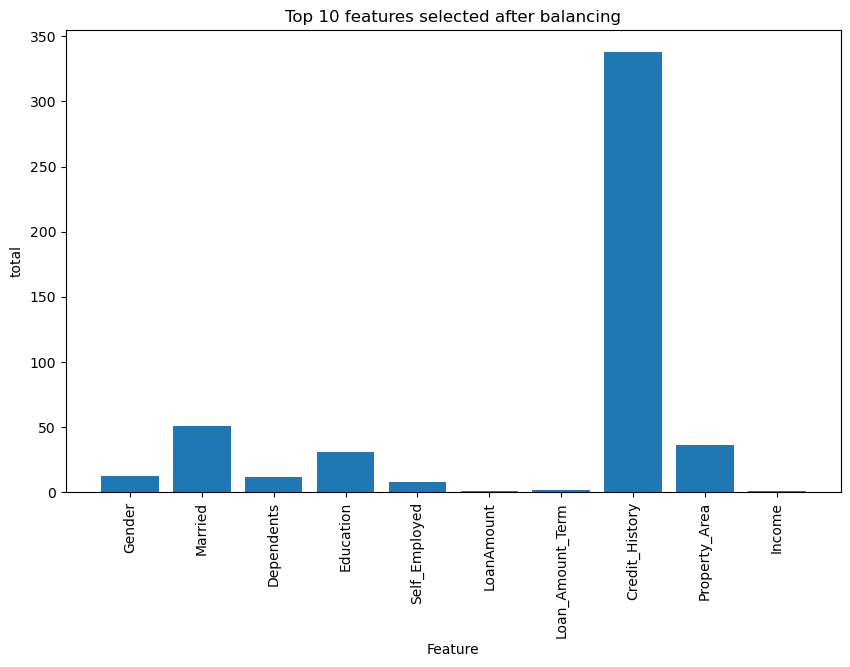

In [53]:
k = 10
selector = SelectKBest(f_classif, k=k)
selector.fit(X, y)
X_topk = selector.transform(X)

# Plot selected features before balancing
plt.figure(figsize=(10,6))
plt.bar(range(len(selector.scores_)), selector.scores_)
plt.xticks(range(len(selector.scores_)), X.columns, rotation=90)
plt.xlabel('Feature')
plt.ylabel('total')
plt.title('Top {} features selected after balancing'.format(k))
plt.show()

In [54]:
# Split the data into train and test sets with an 80/20 split
X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model_80 = xgb.XGBClassifier(random_state=42)# Create an XGBoost classifier
xgb_model_80.fit(X_train_80, y_train_80)# Train the model on the 80/20 split
y_pred_80 = xgb_model_80.predict(X_test_80)# Predict the target values using the testing data from the 80/20 split

# Evaluate the accuracy of the model on the 80/20 split
accuracy_80 = accuracy_score(y_test_80, y_pred_80)
print(f"Accuracy on 80/20 split: {accuracy_80:.2f}")

Accuracy on 80/20 split: 0.84


In [55]:
cm=confusion_matrix(y_test_80, y_pred_80)
df_cm = pd.DataFrame(cm, index=['0','1'], 
                     columns = ['control','Case'])
print(df_cm)

   control  Case
0       76    18
1        9    66


In [56]:
print(classification_report(y_test_80,y_pred_80))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85        94
           1       0.79      0.88      0.83        75

    accuracy                           0.84       169
   macro avg       0.84      0.84      0.84       169
weighted avg       0.85      0.84      0.84       169



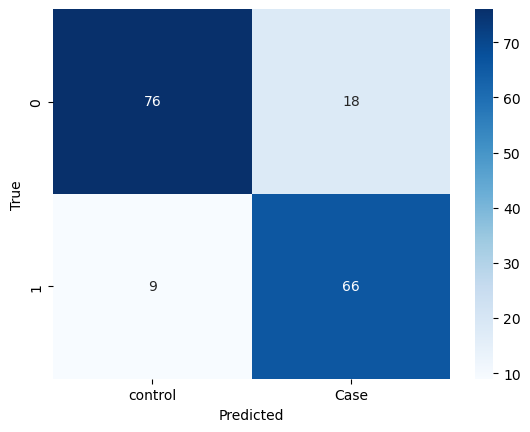

In [57]:
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

AUC-ROC score: 0.8685106382978723


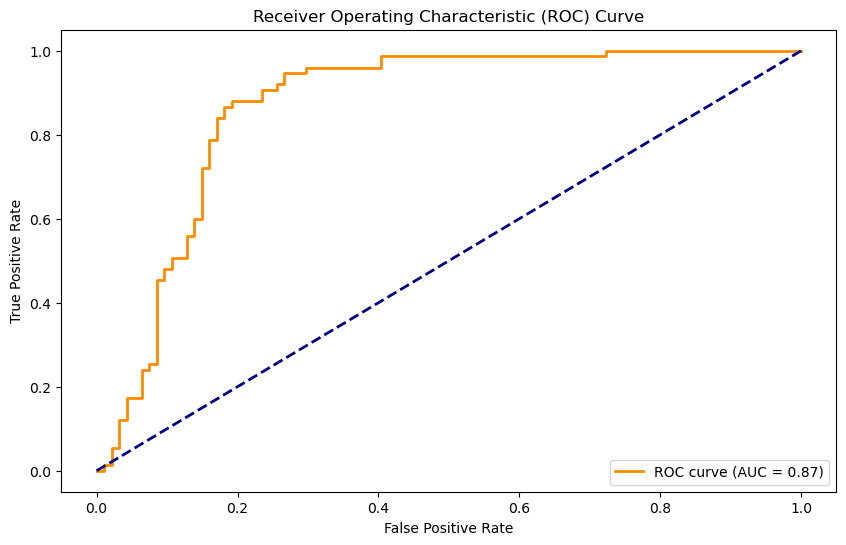

In [58]:
# Predict probabilities for the testing set
y_prob = xgb_model_80.predict_proba(X_test_80)[:,1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test_80, y_prob)
auc_roc = auc(fpr, tpr)
print("AUC-ROC score:", auc_roc)
# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [59]:
# repeat the process for 75/25 split

# Split the data into train and test sets with a 75/25 split
X_train_75, X_test_75, y_train_75, y_test_75 = train_test_split(X, y, test_size=0.25, random_state=42)

xgb_model_75 = xgb.XGBClassifier(random_state=42)# Create an XGBoost classifier
xgb_model_75.fit(X_train_75, y_train_75)# Train the model on the 75/25 split
y_pred_75 = xgb_model_75.predict(X_test_75)# Predict the target values using the testing data from the 75/25 split

# Evaluate the accuracy of the model on the 75/25 split
accuracy_75 = accuracy_score(y_test_75, y_pred_75)
print(f"Accuracy on 75/25 split: {accuracy_75:.2f}")

Accuracy on 75/25 split: 0.81


In [60]:
cm=confusion_matrix(y_test_75, y_pred_75)
df_cm = pd.DataFrame(cm, index=['0','1'], 
                     columns = ['control','Case'])
print(df_cm)

   control  Case
0       89    25
1       15    82


In [61]:
print(classification_report(y_test_75,y_pred_75))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       114
           1       0.77      0.85      0.80        97

    accuracy                           0.81       211
   macro avg       0.81      0.81      0.81       211
weighted avg       0.81      0.81      0.81       211



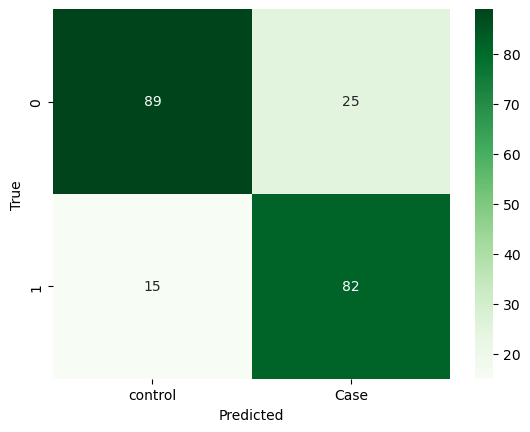

In [62]:
sns.heatmap(df_cm, annot=True, cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

AUC-ROC score: 0.8561222644239466


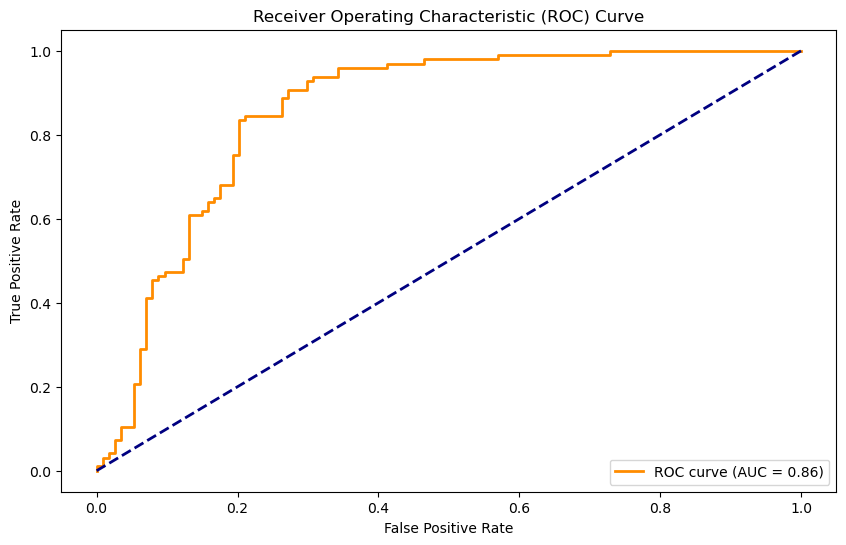

In [63]:
# Predict probabilities for the testing set
y_prob = xgb_model_75.predict_proba(X_test_75)[:,1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test_75, y_prob)
auc_roc = auc(fpr, tpr)
print("AUC-ROC score:", auc_roc)
# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [64]:
# Finally, let's repeat the process for 70/30 split

# Split the data into train and test sets with a 70/30 split
X_train_70, X_test_70, y_train_70, y_test_70 = train_test_split(X, y, test_size=0.3, random_state=42)

# Create an XGBoost classifier
xgb_model_70 = xgb.XGBClassifier(random_state=42)

# Train the model on the 70/30 split
xgb_model_70.fit(X_train_70, y_train_70)

# Predict the target values using the testing data from the 70/30 split
y_pred_70 = xgb_model_70.predict(X_test_70)

# Evaluate the accuracy of the model on the 70/30 split
accuracy_70 = accuracy_score(y_test_70, y_pred_70)
print(f"Accuracy on 70/30 split: {accuracy_70:.2f}")

Accuracy on 70/30 split: 0.78


In [65]:

cm=confusion_matrix(y_test_70, y_pred_70)
df_cm = pd.DataFrame(cm, index=['0','1'], 
                     columns = ['control','Case'])
print(df_cm)

   control  Case
0      105    31
1       24    94


In [66]:
print(classification_report(y_test_70,y_pred_70))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       136
           1       0.75      0.80      0.77       118

    accuracy                           0.78       254
   macro avg       0.78      0.78      0.78       254
weighted avg       0.79      0.78      0.78       254



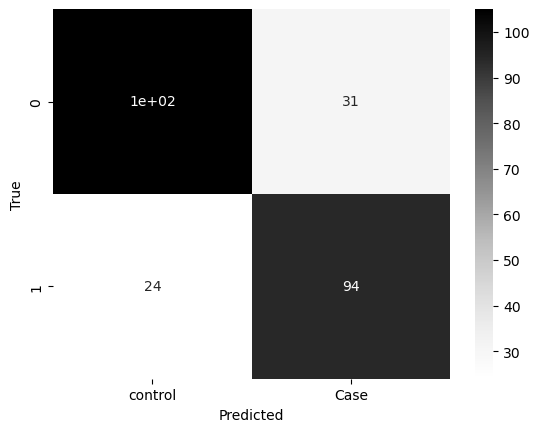

In [67]:
sns.heatmap(df_cm, annot=True, cmap='Greys')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

AUC-ROC score: 0.845681704885344


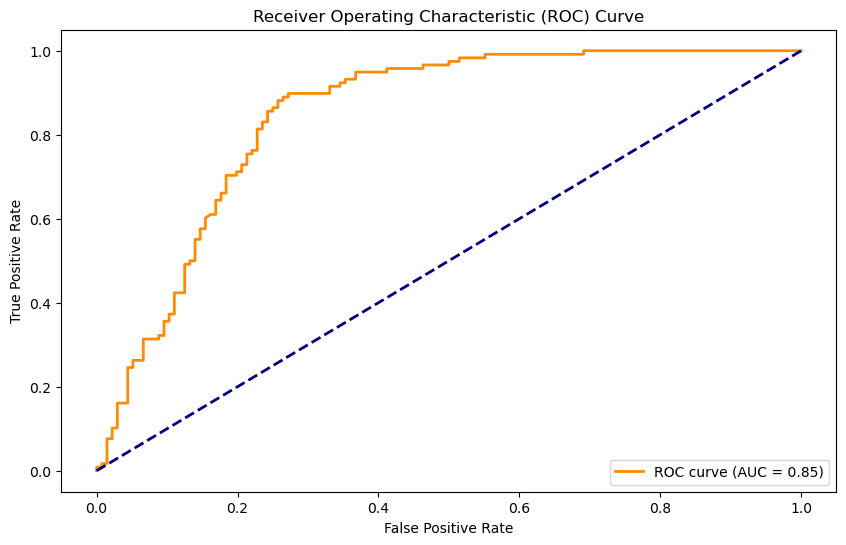

In [68]:
# Predict probabilities for the testing set
y_prob = xgb_model_70.predict_proba(X_test_70)[:,1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test_70, y_prob)
auc_roc = auc(fpr, tpr)
print("AUC-ROC score:", auc_roc)
# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()